## Cartpole 

In [1]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

import seaborn as sns; sns.set_theme()

import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

### Experience replay (Replay Memory)

In [2]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

In [3]:
# Define the replay memory
replay_mem = ReplayMemory(capacity=3)

# Push some samples
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(1,1,1,1)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(2,2,2,2)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(3,3,3,3)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(4,4,4,4)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")
replay_mem.push(5,5,5,5)
print(f"CURRENT MEMORY SIZE: {len(replay_mem)}")

# Check the content of the memory
print('\nCONTENT OF THE MEMORY')
print(replay_mem.memory)

# Random sample
print('\nRANDOM SAMPLING')
for i in range(5):
  print(replay_mem.sample(2)) # Select 2 samples randomly from the memory

CURRENT MEMORY SIZE: 0
CURRENT MEMORY SIZE: 1
CURRENT MEMORY SIZE: 2
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3
CURRENT MEMORY SIZE: 3

CONTENT OF THE MEMORY
deque([(3, 3, 3, 3), (4, 4, 4, 4), (5, 5, 5, 5)], maxlen=3)

RANDOM SAMPLING
[(3, 3, 3, 3), (5, 5, 5, 5)]
[(3, 3, 3, 3), (4, 4, 4, 4)]
[(4, 4, 4, 4), (5, 5, 5, 5)]
[(4, 4, 4, 4), (3, 3, 3, 3)]
[(5, 5, 5, 5), (3, 3, 3, 3)]


# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 64 neurons each). 

Be sure to keep a linear output activation.

## Network definition

In [4]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [5]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [6]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [7]:
# Test if it works as expected
state = (0, 0, 0, 0)
epsilon = 0.5
chosen_action, q_values = choose_action_epsilon_greedy(net, state, epsilon)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.11622948 -0.00056927]


### Softmax policy

In [8]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [29]:
state = (0, 0, 0, 0)
temperature = 1
chosen_action, q_values = choose_action_softmax(net, state, temperature)

print(f"ACTION: {chosen_action}")
print(f"Q-VALUES: {q_values}")

ACTION: 1
Q-VALUES: [-0.11622948 -0.00056927]


### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

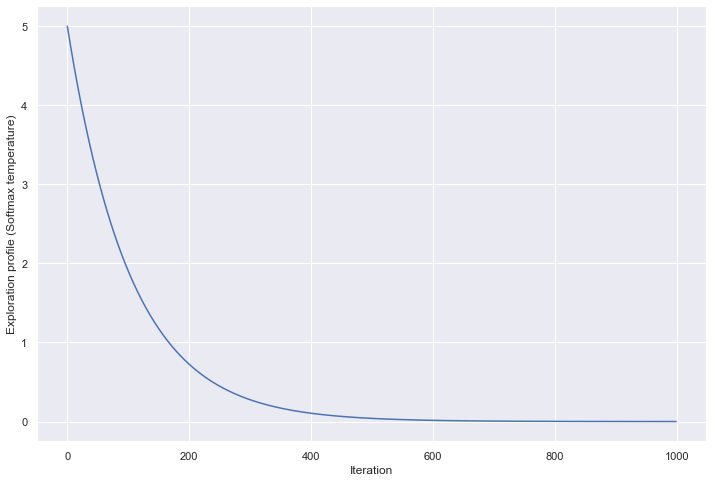

In [30]:
def exp_decay(initial_value, num_iterations=1000):
    exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) 
    exploration_profile = np.array([initial_value * (exp_decay ** i) for i in range(num_iterations)])
    
    return exploration_profile

### Define exploration profile
exploration_profile = exp_decay(5)
### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment (CartPole-v1)

In [11]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


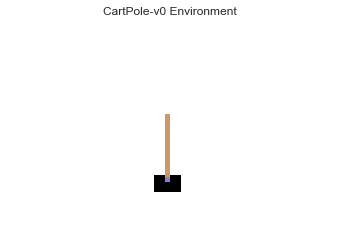

In [12]:
from IPython.display import clear_output

def get_screen():
    ''' Extract one step of the simulation.'''
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255.
    return torch.from_numpy(screen)

# Speify the number of simulation steps
num_steps = 2

# Show several steps
for i in range(num_steps):
    clear_output(wait=True)
    env.reset()
    plt.figure()
    plt.imshow(get_screen().cpu().permute(1, 2, 0).numpy(),
               interpolation='none')
    plt.title('CartPole-v0 Environment')
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [13]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

final_score = []
# Let's try for a total of 10 episodes
for num_episode in range(100): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
    
    # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    final_score.append(score)
    
env.close()



EPISODE 1 - FINAL SCORE: 16.0
EPISODE 2 - FINAL SCORE: 32.0
EPISODE 3 - FINAL SCORE: 16.0
EPISODE 4 - FINAL SCORE: 25.0
EPISODE 5 - FINAL SCORE: 12.0
EPISODE 6 - FINAL SCORE: 27.0
EPISODE 7 - FINAL SCORE: 37.0
EPISODE 8 - FINAL SCORE: 45.0
EPISODE 9 - FINAL SCORE: 11.0
EPISODE 10 - FINAL SCORE: 24.0
EPISODE 11 - FINAL SCORE: 19.0
EPISODE 12 - FINAL SCORE: 12.0
EPISODE 13 - FINAL SCORE: 23.0
EPISODE 14 - FINAL SCORE: 14.0
EPISODE 15 - FINAL SCORE: 19.0
EPISODE 16 - FINAL SCORE: 14.0
EPISODE 17 - FINAL SCORE: 38.0
EPISODE 18 - FINAL SCORE: 17.0
EPISODE 19 - FINAL SCORE: 18.0
EPISODE 20 - FINAL SCORE: 23.0
EPISODE 21 - FINAL SCORE: 12.0
EPISODE 22 - FINAL SCORE: 36.0
EPISODE 23 - FINAL SCORE: 30.0
EPISODE 24 - FINAL SCORE: 20.0
EPISODE 25 - FINAL SCORE: 19.0
EPISODE 26 - FINAL SCORE: 17.0
EPISODE 27 - FINAL SCORE: 21.0
EPISODE 28 - FINAL SCORE: 19.0
EPISODE 29 - FINAL SCORE: 26.0
EPISODE 30 - FINAL SCORE: 12.0
EPISODE 31 - FINAL SCORE: 14.0
EPISODE 32 - FINAL SCORE: 23.0
EPISODE 33 - FINA

Text(0, 0.5, 'Frequency')

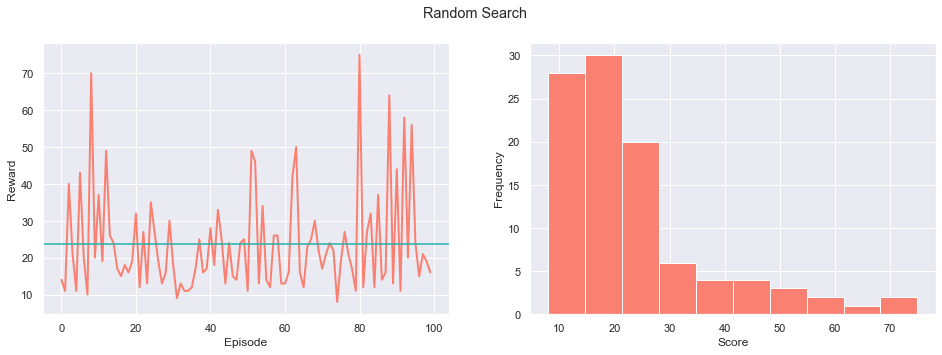

In [15]:
# Define the figure
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
f.suptitle("Random Search")

ax[0].plot(final_score,linewidth = 2 ,  color = 'salmon')
ax[0].axhline(np.mean(final_score),  color = 'lightseagreen')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Reward')

ax[1].hist(final_score, color = 'salmon')
ax[1].set_xlabel('Score')
ax[1].set_ylabel('Frequency')

# Network update

## Initialization

In [14]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [15]:
def initialize(params, replay_memory_capacity=10000, state_space_dim=4, action_space_dim=2):
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=params['lr']) # The optimizer will update ONLY the parameters of the policy network

    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn


## Update function

In [16]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop

In [17]:
def training_loop(policy_net, target_net, replay_mem, exploration_profile, params, verbose=False):
    # Initialize the Gym environment
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    training_score = []

    for episode_num, tau in enumerate(tqdm(exploration_profile)):

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # Choose the action following the policy
            action, q_values = choose_action_softmax(policy_net, state, temperature=tau)

            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            # We apply a (linear) penalty when the cart is far from center
            pos_weight = 1
            reward = reward - pos_weight * np.abs(state[0]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward += params['bad_state_penalty']
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, params['gamma'], optimizer, loss_fn, params['batch_size'])

            # Visually render the environment (disable to speed up the training)
            if episode_num % 100 == 0:
                env.render()

            # Set the current state for the next iteration
            state = next_state

        # Update the target network every target_net_update_steps episodes
        if episode_num % params['target_net_update_steps'] == 0:
            if verbose: print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Print the final score
        if verbose: print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
        training_score.append(score)
    env.close()
    
    return policy_net, training_score

### Exploration profile

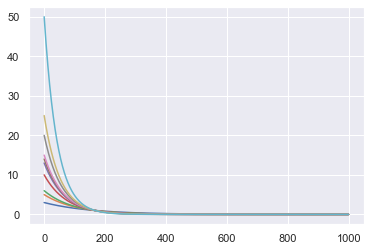

In [35]:
explorations = []
init_val = [3, 5, 6, 10, 13,14, 15, 20, 25, 50]
for i in init_val:
    exp = exp_decay(initial_value=i)       
    explorations.append(exp)
    plt.plot(exp)

In [36]:
len(explorations)

10

In [37]:
parameters = []
final_score = []
final_profile = []


target_net_update_steps = np.arange(5, 25, 5, dtype=int)
gamma = np.linspace(0.9, 0.99, 10)
lr = np.logspace(-2, -1, 100)
batch_size = [32, 64, 128]

for i in range(len(explorations)):
    
    ### Set exploration profile
    exploration_profile = explorations[i]
    
    ### PARAMETERS
    params = {}
    params['gamma'] = np.random.choice(gamma)   # gamma parameter for the long term reward
    replay_memory_capacity = 10000   # Replay memory capacity
    params['lr'] = np.random.choice(lr)   # Optimizer learning rate
    params['target_net_update_steps'] = np.random.choice(target_net_update_steps)   # Number of episodes to wait before updating the target network
    params['batch_size'] = np.random.choice(batch_size)  # Number of samples to take from the replay memory for each update
    params['bad_state_penalty'] = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
    
    min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

    ### Initialization
    replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(params)
    
    ### Training
    policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                                params, verbose=False)
    
    parameters.append(params)
    final_score.append(training_score)
    final_profile.append(exploration_profile)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
def plot_results(scores, params):
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    
    text = ''
    for i in params.keys():
        if type(params[i]) == int:
            text += i + (' : $ %i $, ' %(params[i]) )
        else:
            text += i + (' : $ %.3f $, ' %(params[i]) )
    
    f.suptitle(text)
    
    ax[0].plot(scores,linewidth = 2 ,  color = 'salmon')
    ax[0].axhline(np.mean(final_score),  color = 'lightseagreen')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')
    
    ax[1].hist(scores, color = 'salmon')
    ax[1].set_xlabel('Score')
    ax[1].set_ylabel('Frequency')
 


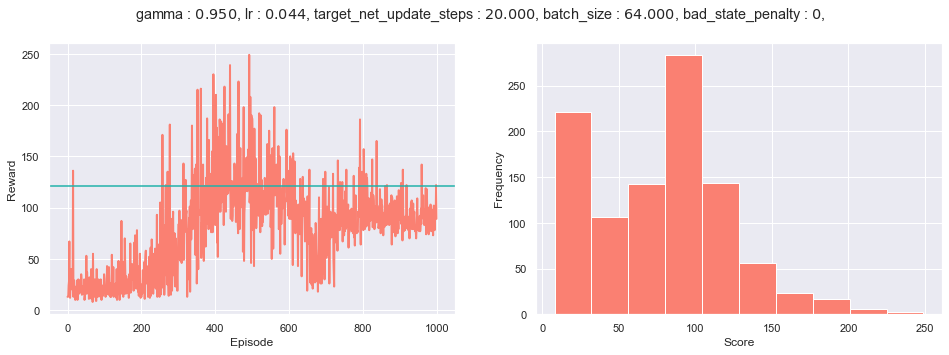

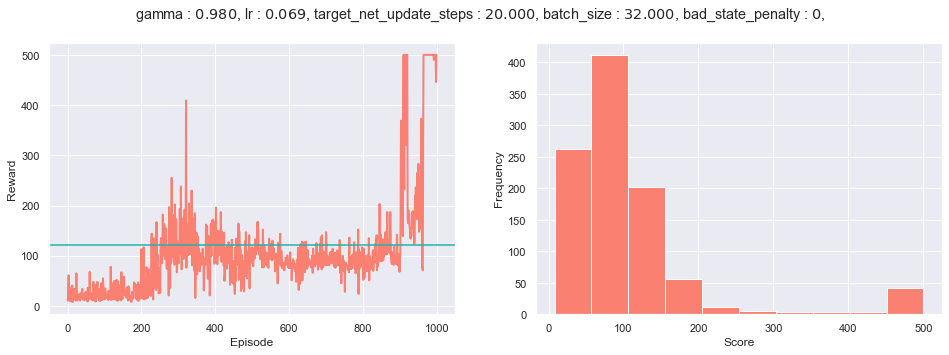

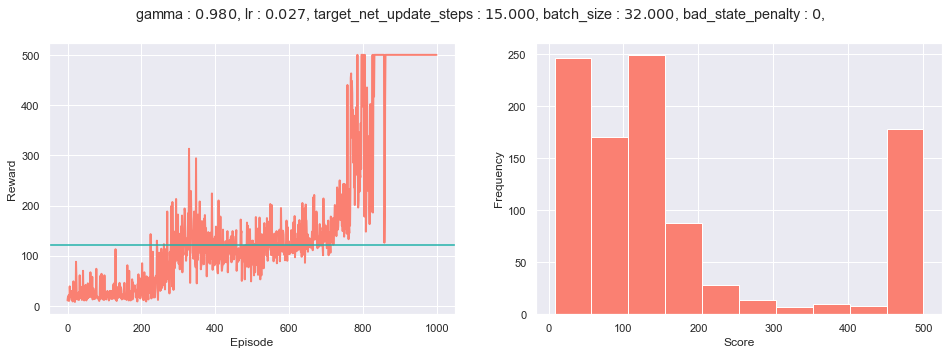

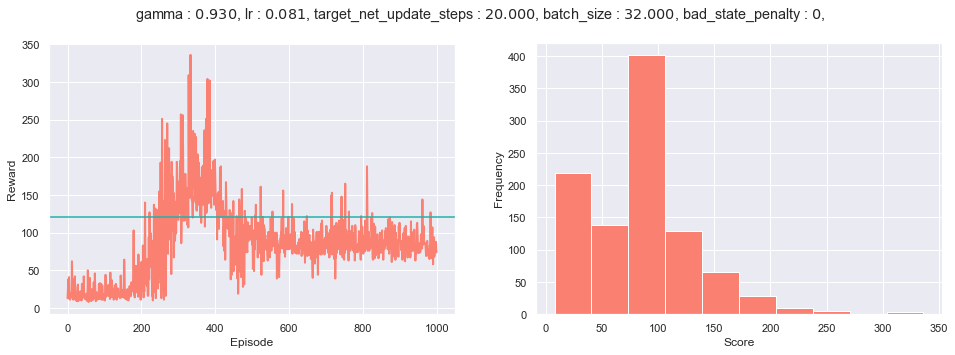

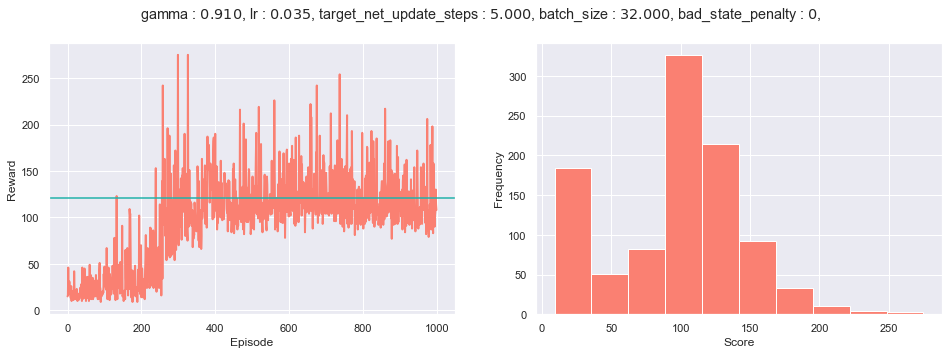

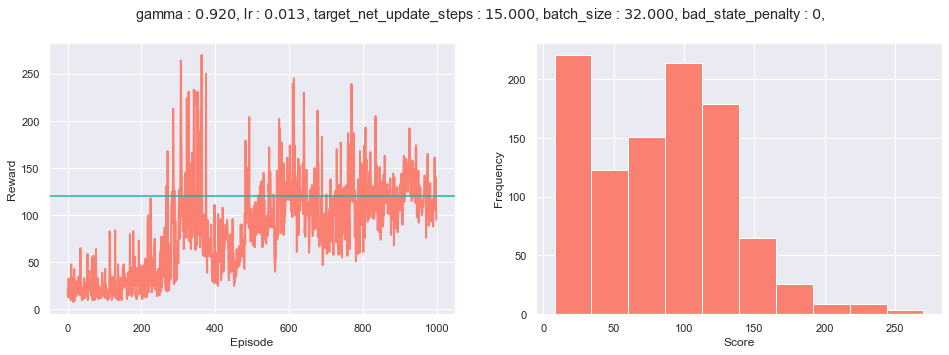

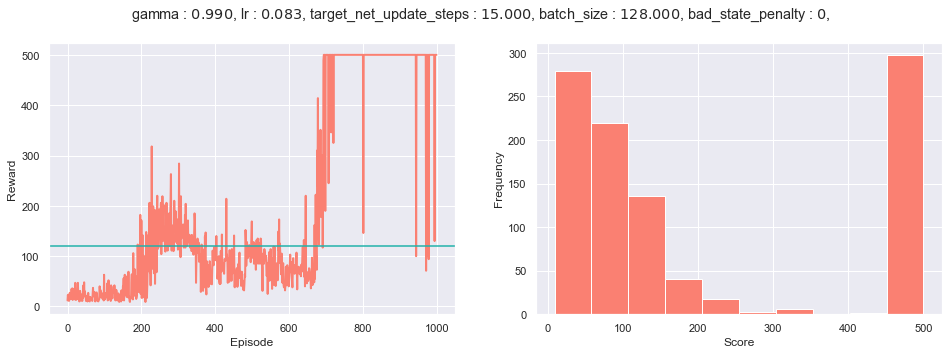

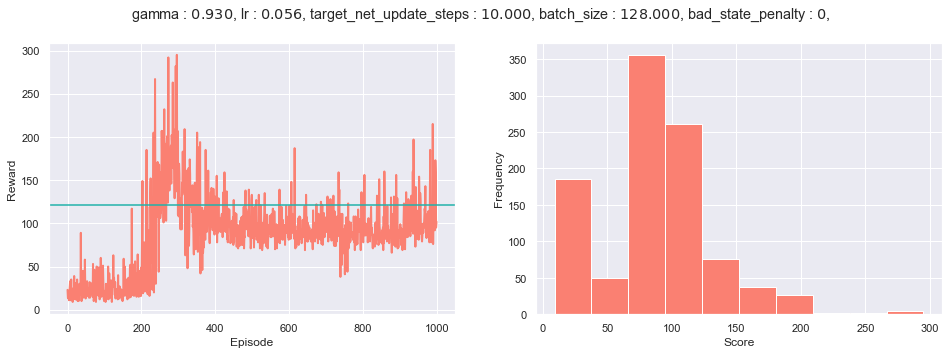

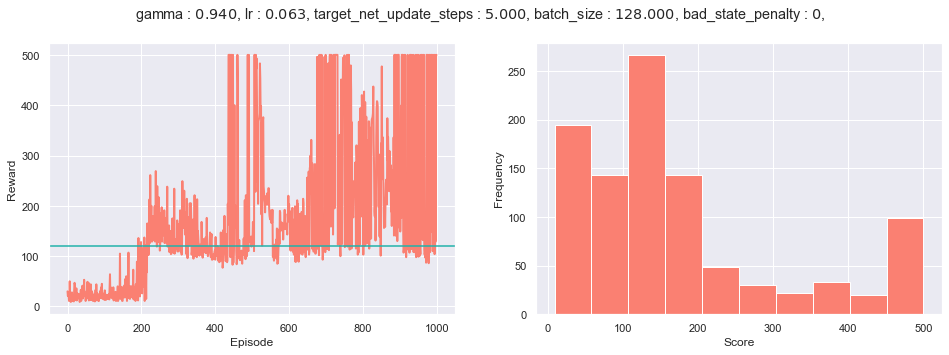

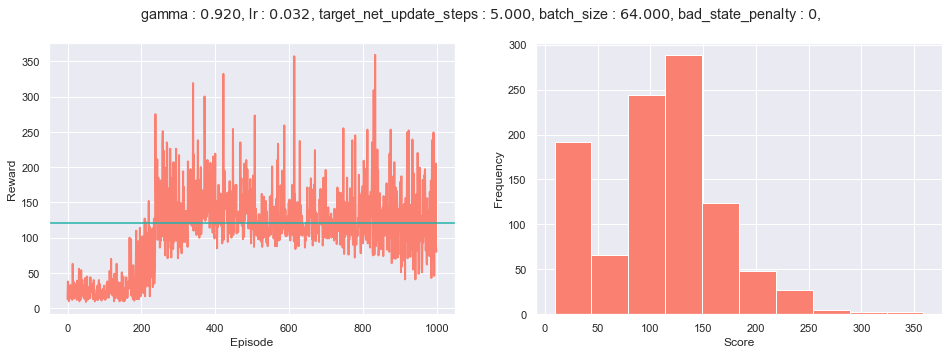

In [39]:
for i in range(len(explorations)):
    plot_results(final_score[i], parameters[i] )

In [40]:
#found the first to be solved
for i in range(len(explorations)):
    temp = np.argwhere( np.array(final_score[i])>=490 )
    if len(temp)>0:
        parameters[i]['first_solved'] = temp[0][0]
    else:
        parameters[i]['first_solved'] = 1000
        
for i in parameters:
    for k in i.keys():
        if type(i[k])==np.int32 or type(i[k])==np.int64:
            i[k] = int( i[k] )
        elif type(i[k])==np.float32 or type(i[k])==np.float64:
            i[k] = float( i[k] )

In [41]:
first = []
for i in range(len(parameters)):
    first.append(parameters[i]['first_solved'])

In [42]:
parameters

[{'gamma': 0.95,
  'lr': 0.044306214575838825,
  'target_net_update_steps': 20,
  'batch_size': 64,
  'bad_state_penalty': 0,
  'first_solved': 1000},
 {'gamma': 0.98,
  'lr': 0.06892612104349699,
  'target_net_update_steps': 20,
  'batch_size': 32,
  'bad_state_penalty': 0,
  'first_solved': 910},
 {'gamma': 0.98,
  'lr': 0.026560877829466867,
  'target_net_update_steps': 15,
  'batch_size': 32,
  'bad_state_penalty': 0,
  'first_solved': 785},
 {'gamma': 0.93,
  'lr': 0.08111308307896872,
  'target_net_update_steps': 20,
  'batch_size': 32,
  'bad_state_penalty': 0,
  'first_solved': 1000},
 {'gamma': 0.91,
  'lr': 0.03511191734215131,
  'target_net_update_steps': 5,
  'batch_size': 32,
  'bad_state_penalty': 0,
  'first_solved': 1000},
 {'gamma': 0.92,
  'lr': 0.012618568830660204,
  'target_net_update_steps': 15,
  'batch_size': 32,
  'bad_state_penalty': 0,
  'first_solved': 1000},
 {'gamma': 0.99,
  'lr': 0.08302175681319744,
  'target_net_update_steps': 15,
  'batch_size': 128,


Text(0, 0.5, 'Exploration profile (Softmax temperature)')

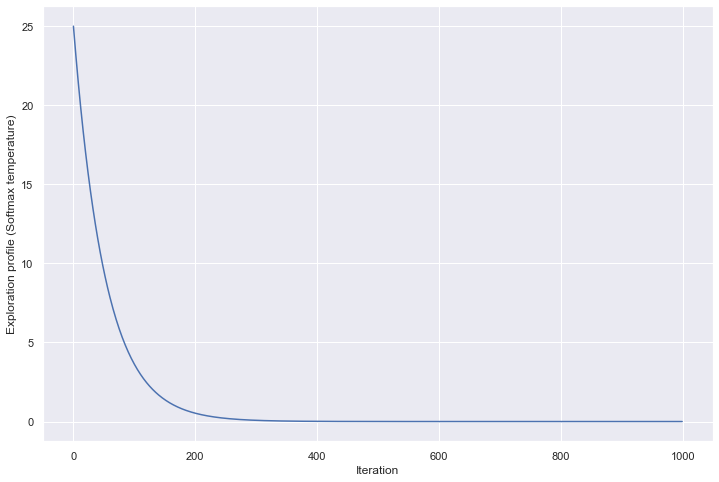

In [44]:
#best profile
plt.figure(figsize=(12,8))
plt.plot(explorations[8])
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Final test

In [47]:
### Initialization
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize(parameters[8])

### Training
policy_net, training_score = training_loop(policy_net, target_net, replay_mem, exploration_profile, 
                                            parameters[8], verbose=False)

0it [00:00, ?it/s]

TypeError: 'numpy.float64' object is not iterable

In [46]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 177.0
EPISODE 2 - FINAL SCORE: 183.0
EPISODE 3 - FINAL SCORE: 102.0
EPISODE 4 - FINAL SCORE: 147.0
EPISODE 5 - FINAL SCORE: 112.0
EPISODE 6 - FINAL SCORE: 117.0
EPISODE 7 - FINAL SCORE: 175.0
EPISODE 8 - FINAL SCORE: 96.0
EPISODE 9 - FINAL SCORE: 222.0
EPISODE 10 - FINAL SCORE: 110.0
